In [178]:
import warnings
#warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import collections

In [179]:
STAT_COLUMNS = [
    'st', 'carav', 'g', 
    'cmp', 'pass_att', 'pass_yds', 'pass_td', 'pass_int',
    'rush_att', 'rush_yds', 'rush_tds',
    'rec', 'rec_yds', 'rec_tds', 'tkl',
    'def_int'
]

POSITION_DEPENDENT_FEATURES = [
    'cmp', 'pass_att', 'pass_yds', 'pass_td', 'pass_int', 'rush_att', 'rush_yds', 'rush_tds', 'rec', 'rec_yds', 'rec_tds', 'tkl', 'def_int', 'sk', 
]


In [180]:
# import and preview dataset
data = pd.read_csv("nfl_draft.csv")
data.head()

,column_a,player_id,year,rnd,pick,tm,player,hof,pos,position_standard,first4av,age,to,ap1,pb,st,carav,drav,g,cmp,pass_att,pass_yds,pass_td,pass_int,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,tkl,def_int,sk,college_univ
0,2015Jameis Winston,WinsJa00,2015,1,1,TAM,Jameis Winston,No,QB,QB,13,21.0,2016.0,0,1,2,13.0,13.0,26.0,540.0,913.0,6722.0,42.0,25.0,86.0,311.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,Florida St.
1,2015Marcus Mariota,MariMa01,2015,1,2,TEN,Marcus Mariota,No,QB,QB,9,21.0,2016.0,0,0,2,9.0,9.0,23.0,458.0,725.0,5590.0,42.0,18.0,79.0,516.0,4.0,1.0,41.0,1.0,NaN,NaN,NaN,Oregon
2,2015Dante Fowler,FowlDa00,2015,1,3,JAX,Dante Fowler,No,OLB,LB,0,21.0,2016.0,0,0,0,0.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,2.5,Florida
3,2015Amari Cooper,CoopAm00,2015,1,4,OAK,Amari Cooper,No,WR,WR,9,21.0,2016.0,0,1,1,9.0,9.0,26.0,NaN,NaN,NaN,NaN,NaN,3.0,-3.0,0.0,134.0,1970.0,9.0,NaN,NaN,NaN,Alabama
4,2015Brandon Scherff,ScheBr00,2015,1,5,WAS,Brandon Scherff,No,T,T,7,23.0,2016.0,0,0,2,7.0,7.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Iowa


In [181]:
# frequency of null entries in each feature
data.isnull().sum()

column_a                0
player_id            1219
year                    0
rnd                     0
pick                    0
tm                      0
player                  0
hof                     0
pos                     0
position_standard       0
first4av                0
age                  1245
to                   1382
ap1                     0
pb                      0
st                      0
carav                1382
drav                 2165
g                    1415
cmp                  7841
pass_att             7841
pass_yds             7841
pass_td              7841
pass_int             7841
rush_att             6789
rush_yds             6789
rush_tds             6789
rec                  6264
rec_yds              6264
rec_tds              6264
tkl                  4324
def_int              6819
sk                   4388
college_univ         3430
dtype: int64

In [182]:
#Many features have null values. We suspect that the reason is that some
#positions do not do things that other positions do. For example, a linebacker
#will likely never throw a football, so they will have null for cmp
#(completions)

#let's verify and check how many QB's have null completions vs total amount of
#null completions
null_cmps = data[data['cmp'].isnull()]
null_cmps


,column_a,player_id,year,rnd,pick,tm,player,hof,pos,position_standard,first4av,age,to,ap1,pb,st,carav,drav,g,cmp,pass_att,pass_yds,pass_td,pass_int,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,tkl,def_int,sk,college_univ
2,2015Dante Fowler,FowlDa00,2015,1,3,JAX,Dante Fowler,No,OLB,LB,0,21.0,2016.0,0,0,0,0.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,2.5,Florida
3,2015Amari Cooper,CoopAm00,2015,1,4,OAK,Amari Cooper,No,WR,WR,9,21.0,2016.0,0,1,1,9.0,9.0,26.0,NaN,NaN,NaN,NaN,NaN,3.0,-3.0,0.0,134.0,1970.0,9.0,NaN,NaN,NaN,Alabama
4,2015Brandon Scherff,ScheBr00,2015,1,5,WAS,Brandon Scherff,No,T,T,7,23.0,2016.0,0,0,2,7.0,7.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Iowa
5,2015Leonard Williams,WillLe02,2015,1,6,NYJ,Leonard Williams,No,DE,DE,9,21.0,2016.0,0,0,2,9.0,9.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,NaN,9,USC
6,2015Kevin White,WhitKe00,2015,1,7,CHI,Kevin White,No,WR,WR,0,23.0,2016.0,0,0,0,0.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,1.0,9.0,0.0,19.0,187.0,0.0,NaN,NaN,NaN,West Virginia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8430,1985Raymond Polk,NaN,1985,12,332,RAI,Raymond Polk,No,DB,DB,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oklahoma St.,NaN
8431,1985Paul Woodside,NaN,1985,12,333,BUF,Paul Woodside,No,K,K,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West Virginia,NaN
8432,1985Dan Lynch,NaN,1985,12,334,DEN,Dan Lynch,No,G,G,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Washington St.,NaN
8433,1985Ray Noble,NaN,1985,12,335,MIA,Ray Noble,No,DB,DB,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,California,NaN


In [183]:
null_cmps.loc[null_cmps['pos'] == 'QB']

# as we can see, very few QB positions have null values for cmp while many non
# QB positions do. Because of this, we think it is best to impute a value of 0 
# for the position-dependent features completions, rush attempts, touchdowns, 
# etc) 

,column_a,player_id,year,rnd,pick,tm,player,hof,pos,position_standard,first4av,age,to,ap1,pb,st,carav,drav,g,cmp,pass_att,pass_yds,pass_td,pass_int,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,tkl,def_int,sk,college_univ
74,2015Garrett Grayson,GrayGa00,2015,3,75,NOR,Garrett Grayson,No,QB,QB,0,24.0,2015.0,0,0,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Colorado St.
418,2014Aaron Murray,MurrAa00,2014,5,163,KAN,Aaron Murray,No,QB,QB,0,23.0,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Georgia
438,2014David Fales,FaleDa00,2014,6,183,CHI,David Fales,No,QB,QB,0,23.0,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,San Jose St.
449,2014Keith Wenning,WennKe00,2014,6,194,BAL,Keith Wenning,No,QB,QB,0,23.0,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ball St.
468,2014Tajh Boyd,BoydTa00,2014,6,213,NYJ,Tajh Boyd,No,QB,QB,0,24.0,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clemson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8330,1985Steve Calabria,NaN,1985,9,232,TAM,Steve Calabria,No,QB,QB,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Colgate,NaN
8332,1985Paul Berner,NaN,1985,9,234,SDG,Paul Berner,No,QB,QB,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific,NaN
8367,1985Buddy Funck,NaN,1985,10,269,DEN,Buddy Funck,No,QB,QB,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,NaN
8375,1985John Conner,NaN,1985,10,277,SEA,John Conner,No,QB,QB,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arizona,NaN


In [184]:
data[POSITION_DEPENDENT_FEATURES] = data[POSITION_DEPENDENT_FEATURES].fillna(0)
data.isnull().sum()

column_a                0
player_id            1219
year                    0
rnd                     0
pick                    0
tm                      0
player                  0
hof                     0
pos                     0
position_standard       0
first4av                0
age                  1245
to                   1382
ap1                     0
pb                      0
st                      0
carav                1382
drav                 2165
g                    1415
cmp                     0
pass_att                0
pass_yds                0
pass_td                 0
pass_int                0
rush_att                0
rush_yds                0
rush_tds                0
rec                     0
rec_yds                 0
rec_tds                 0
tkl                     0
def_int                 0
sk                      0
college_univ         3430
dtype: int64

In [185]:
data['position_standard'].value_counts()
#LS is a specialized version of C, so we can combine the two into the same position


DB    1569
LB    1124
WR    1049
RB     809
DE     731
DT     640
T      619
G      542
TE     496
QB     398
C      225
K       78
FB      77
P       77
LS       1
Name: position_standard, dtype: int64

In [186]:
data['position_standard'] = data['position_standard'].replace(['LS'], 'C')
data['position_standard'].value_counts()

DB    1569
LB    1124
WR    1049
RB     809
DE     731
DT     640
T      619
G      542
TE     496
QB     398
C      226
K       78
FB      77
P       77
Name: position_standard, dtype: int64

In [187]:
print(data['rnd'].corr(data['drav']))
print(data['rnd'].corr(data['carav']))
print(data['drav'].corr(data['carav']))


#drav and carav basically describe the same thing (career average and draft
#average)
#this can be seen from their correlation value
#we decide to drop drav because corr with rnd lower than carav and they are similar
data[['st', 'g', 'cmp', 'pass_att',
       'pass_yds', 'pass_td', 'pass_int', 'rush_att', 'rush_yds', 'rush_tds',
       'rec', 'rec_yds', 'rec_tds', 'tkl', 'def_int', 'sk']].head()

-0.36528440711228094
-0.3756977577406549
0.8715160708472572


,st,g,cmp,pass_att,pass_yds,pass_td,pass_int,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,tkl,def_int,sk
0,2,26.0,540.0,913.0,6722.0,42.0,25.0,86.0,311.0,7.0,0.0,0.0,0.0,0.0,0.0,0
1,2,23.0,458.0,725.0,5590.0,42.0,18.0,79.0,516.0,4.0,1.0,41.0,1.0,0.0,0.0,0
2,0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,2.5
3,1,26.0,0.0,0.0,0.0,0.0,0.0,3.0,-3.0,0.0,134.0,1970.0,9.0,0.0,0.0,0
4,2,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [188]:
def transform(x):
  if(x['year'] <= 1993): #rounds before 1993 did not have 32 rounds per pick. We should standardize to today's standard
    x['rnd'] = 1 + int(x['pick'] / 32)
  return x

data = data.apply(func=transform, axis=1, result_type='broadcast')



In [189]:
# data.loc[data['rnd'] <= 3, 'rnd'] = 1
# data.loc[(data['rnd'] > 3) & (data['rnd'] <= 6) , 'rnd'] = 4
# data.loc[data['rnd'] > 6, 'rnd'] = 7
data

,column_a,player_id,year,rnd,pick,tm,player,hof,pos,position_standard,first4av,age,to,ap1,pb,st,carav,drav,g,cmp,pass_att,pass_yds,pass_td,pass_int,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,tkl,def_int,sk,college_univ
0,2015Jameis Winston,WinsJa00,2015,1,1,TAM,Jameis Winston,No,QB,QB,13,21.0,2016.0,0,1,2,13.0,13.0,26.0,540.0,913.0,6722.0,42.0,25.0,86.0,311.0,7.0,0.0,0.0,0.0,0.0,0.0,0,Florida St.
1,2015Marcus Mariota,MariMa01,2015,1,2,TEN,Marcus Mariota,No,QB,QB,9,21.0,2016.0,0,0,2,9.0,9.0,23.0,458.0,725.0,5590.0,42.0,18.0,79.0,516.0,4.0,1.0,41.0,1.0,0.0,0.0,0,Oregon
2,2015Dante Fowler,FowlDa00,2015,1,3,JAX,Dante Fowler,No,OLB,LB,0,21.0,2016.0,0,0,0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,2.5,Florida
3,2015Amari Cooper,CoopAm00,2015,1,4,OAK,Amari Cooper,No,WR,WR,9,21.0,2016.0,0,1,1,9.0,9.0,26.0,0.0,0.0,0.0,0.0,0.0,3.0,-3.0,0.0,134.0,1970.0,9.0,0.0,0.0,0,Alabama
4,2015Brandon Scherff,ScheBr00,2015,1,5,WAS,Brandon Scherff,No,T,T,7,23.0,2016.0,0,0,2,7.0,7.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Iowa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8430,1985Raymond Polk,NaN,1985,11,332,RAI,Raymond Polk,No,DB,DB,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Oklahoma St.,NaN
8431,1985Paul Woodside,NaN,1985,11,333,BUF,Paul Woodside,No,K,K,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,West Virginia,NaN
8432,1985Dan Lynch,NaN,1985,11,334,DEN,Dan Lynch,No,G,G,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Washington St.,NaN
8433,1985Ray Noble,NaN,1985,11,335,MIA,Ray Noble,No,DB,DB,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,California,NaN


In [190]:
labels = data['rnd']

#pick directly correlates with round. keeping it as a feature would be data leakage
features = data.drop(['pick'], axis=1)
features.drop(['drav'], axis=1)
print(features.head())

              column_a player_id  year rnd   tm           player hof  pos  \
0   2015Jameis Winston  WinsJa00  2015   1  TAM   Jameis Winston  No   QB   
1   2015Marcus Mariota  MariMa01  2015   1  TEN   Marcus Mariota  No   QB   
2     2015Dante Fowler  FowlDa00  2015   1  JAX     Dante Fowler  No  OLB   
3     2015Amari Cooper  CoopAm00  2015   1  OAK     Amari Cooper  No   WR   
4  2015Brandon Scherff  ScheBr00  2015   1  WAS  Brandon Scherff  No    T   

  position_standard first4av   age      to ap1 pb st carav  drav     g    cmp  \
0                QB       13  21.0  2016.0   0  1  2  13.0  13.0  26.0  540.0   
1                QB        9  21.0  2016.0   0  0  2   9.0   9.0  23.0  458.0   
2                LB        0  21.0  2016.0   0  0  0   0.0   0.0  10.0    0.0   
3                WR        9  21.0  2016.0   0  1  1   9.0   9.0  26.0    0.0   
4                 T        7  23.0  2016.0   0  0  2   7.0   7.0  27.0    0.0   

  pass_att pass_yds pass_td pass_int rush_att rush

In [191]:
print(data['rnd'])



0        1
1        1
2        1
3        1
4        1
        ..
8430    11
8431    11
8432    11
8433    11
8434    11
Name: rnd, Length: 8435, dtype: object


In [192]:
'''
Dropping ap1 (Deals with all pro designation), pb (Deals with Pro Bowler
designation), hof (hall of fame designation)
This is future data (received after they were drafted and cannot be used in
prediction)
'''
features = data.drop(['ap1', 'pb', 'to'], axis=1)

#unneeded  things like name/player id, team, etc. Does not help with our prediction
features.drop(['column_a','player_id','tm', 'hof', 'player', 'pos'], axis=1, inplace=True)

#drop things with too many nulls that cannot be imputed
features.drop(['college_univ'], axis=1, inplace=True)

print(features.columns)

Index(['year', 'rnd', 'pick', 'position_standard', 'first4av', 'age', 'st',
       'carav', 'drav', 'g', 'cmp', 'pass_att', 'pass_yds', 'pass_td',
       'pass_int', 'rush_att', 'rush_yds', 'rush_tds', 'rec', 'rec_yds',
       'rec_tds', 'tkl', 'def_int', 'sk'],
      dtype='object')


In [193]:
null_cmps.loc[null_cmps['pos'] == 'QB']

,column_a,player_id,year,rnd,pick,tm,player,hof,pos,position_standard,first4av,age,to,ap1,pb,st,carav,drav,g,cmp,pass_att,pass_yds,pass_td,pass_int,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,tkl,def_int,sk,college_univ
74,2015Garrett Grayson,GrayGa00,2015,3,75,NOR,Garrett Grayson,No,QB,QB,0,24.0,2015.0,0,0,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Colorado St.
418,2014Aaron Murray,MurrAa00,2014,5,163,KAN,Aaron Murray,No,QB,QB,0,23.0,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Georgia
438,2014David Fales,FaleDa00,2014,6,183,CHI,David Fales,No,QB,QB,0,23.0,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,San Jose St.
449,2014Keith Wenning,WennKe00,2014,6,194,BAL,Keith Wenning,No,QB,QB,0,23.0,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ball St.
468,2014Tajh Boyd,BoydTa00,2014,6,213,NYJ,Tajh Boyd,No,QB,QB,0,24.0,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clemson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8330,1985Steve Calabria,NaN,1985,9,232,TAM,Steve Calabria,No,QB,QB,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Colgate,NaN
8332,1985Paul Berner,NaN,1985,9,234,SDG,Paul Berner,No,QB,QB,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific,NaN
8367,1985Buddy Funck,NaN,1985,10,269,DEN,Buddy Funck,No,QB,QB,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,NaN
8375,1985John Conner,NaN,1985,10,277,SEA,John Conner,No,QB,QB,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arizona,NaN


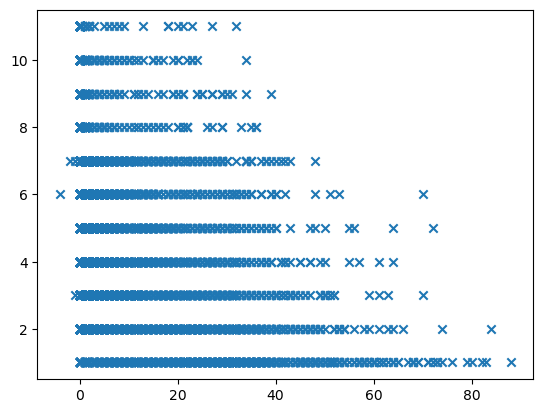

In [194]:
features[['first4av', 'rnd']]
plt.scatter(x=features['first4av'], y=features['rnd'], marker='x')

In [195]:
one_hot = pd.get_dummies(features['position_standard'])
features = features.drop(['position_standard', 'rnd', 'pick'], axis=1)

features = features.join(one_hot)
features

,year,first4av,age,st,carav,drav,g,cmp,pass_att,pass_yds,pass_td,pass_int,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,tkl,def_int,sk,C,DB,DE,DT,FB,G,K,LB,P,QB,RB,T,TE,WR
0,2015,13,21.0,2,13.0,13.0,26.0,540.0,913.0,6722.0,42.0,25.0,86.0,311.0,7.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2015,9,21.0,2,9.0,9.0,23.0,458.0,725.0,5590.0,42.0,18.0,79.0,516.0,4.0,1.0,41.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2015,0,21.0,0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,2.5,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2015,9,21.0,1,9.0,9.0,26.0,0.0,0.0,0.0,0.0,0.0,3.0,-3.0,0.0,134.0,1970.0,9.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2015,7,23.0,2,7.0,7.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8430,1985,0,NaN,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Oklahoma St.,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8431,1985,0,NaN,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,West Virginia,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8432,1985,0,NaN,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Washington St.,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8433,1985,0,NaN,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,California,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [196]:
# use counter to get frequency of each label
frequency = collections.Counter(labels)

# printing the frequency to view any class imbalances between the rounds
print(dict(frequency))

{1: 970, 2: 985, 3: 1041, 4: 1075, 5: 1063, 6: 1127, 7: 1284, 8: 257, 9: 256, 10: 256, 11: 121}


In [197]:
print(features.columns)
pd.set_option("display.max.columns", None)
features[features.isin(['Washington']).any(axis=1)]

#for some reason sk - sacks - contains strings. change these to 0
def transformation(x):
    if isinstance(x, str):
        return 0
features['sk'] = features['sk'].apply(func=transformation)


Index(['year', 'first4av', 'age', 'st', 'carav', 'drav', 'g', 'cmp',
       'pass_att', 'pass_yds', 'pass_td', 'pass_int', 'rush_att', 'rush_yds',
       'rush_tds', 'rec', 'rec_yds', 'rec_tds', 'tkl', 'def_int', 'sk', 'C',
       'DB', 'DE', 'DT', 'FB', 'G', 'K', 'LB', 'P', 'QB', 'RB', 'T', 'TE',
       'WR'],
      dtype='object')


In [198]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
# params = {"max_depth": [5,10,15,20], "min_samples_leaf": [5,10,15,20]}
# grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy') #inner loop
# replace clf with grid_search if you want to test parameters
nested_score = cross_val_score(clf, features, labels, cv=5) #outer loop
print("Accuracy:", nested_score.mean()*100)

Accuracy: nan


c:\Users\lawso\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lawso\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lawso\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "c:\Users\lawso\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 165, in fit
    X, y = self._validate_data(
  File "c:\Users\lawso\anaconda3\lib\site-packages\sklearn\base.py", line 

In [199]:
labels = labels.astype('int')

In [200]:
features = features.fillna(0)
print(features.isna().sum())


year        0
first4av    0
age         0
st          0
carav       0
drav        0
g           0
cmp         0
pass_att    0
pass_yds    0
pass_td     0
pass_int    0
rush_att    0
rush_yds    0
rush_tds    0
rec         0
rec_yds     0
rec_tds     0
tkl         0
def_int     0
sk          0
C           0
DB          0
DE          0
DT          0
FB          0
G           0
K           0
LB          0
P           0
QB          0
RB          0
T           0
TE          0
WR          0
dtype: int64


In [201]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
params = {"max_depth": [5,10,15,20], "min_samples_leaf": [5,10,15,20]}
grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy') #inner loop
# replace clf with grid_search if you want to test parameters
nested_score = cross_val_score(grid_search, features, labels, cv=5, error_score='raise') #outer loop
print("Accuracy:", nested_score.mean()*100)

Accuracy: 18.494368701837583


In [202]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
scores = cross_val_score(clf, features, labels, cv=10)                                       
print("Accuracy:", scores.mean()*100)

#Alternative (cross_val_predict instead of cross_val_score) to analyze the results in more detail:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
clf = GaussianNB()
predicts = cross_val_predict(clf, features, labels, cv=10) 
print("Predictions:", predicts) 
print("Confusion Matrix:\n", confusion_matrix(labels, predicts))
print("Report:\n", classification_report(labels, predicts))



Accuracy: 12.374756146239172
Predictions: [ 1  6  7 ... 11 11 11]
Confusion Matrix:
 [[308 127  89   7 155   8  79  13  11   7 166]
 [136 109  64  14 182   6 134  11   5  14 310]
 [ 72  51  48  12 168  11 199   5  15  19 441]
 [ 51  44  42  15 156   8 244   3  15  24 473]
 [ 30  31  24   3 113  14 261   3   7  24 553]
 [ 22  14  24  14  89   4 301   4   7  23 625]
 [ 22  19  20   2  92   8 325   4  12  32 748]
 [  8   0   0   1   2   0   0   0   4   5 237]
 [  3   2   0   0   1   0   0   2   2   4 242]
 [  1   1   2   0   0   0   1   1   5   7 238]
 [  1   2   0   0   0   0   0   1   0   4 113]]
Report:
               precision    recall  f1-score   support

           1       0.47      0.32      0.38       970
           2       0.27      0.11      0.16       985
           3       0.15      0.05      0.07      1041
           4       0.22      0.01      0.03      1075
           5       0.12      0.11      0.11      1063
           6       0.07      0.00      0.01      1127
         

In [203]:
data.head()

,column_a,player_id,year,rnd,pick,tm,player,hof,pos,position_standard,first4av,age,to,ap1,pb,st,carav,drav,g,cmp,pass_att,pass_yds,pass_td,pass_int,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,tkl,def_int,sk,college_univ
0,2015Jameis Winston,WinsJa00,2015,1,1,TAM,Jameis Winston,No,QB,QB,13,21.0,2016.0,0,1,2,13.0,13.0,26.0,540.0,913.0,6722.0,42.0,25.0,86.0,311.0,7.0,0.0,0.0,0.0,0.0,0.0,0,Florida St.
1,2015Marcus Mariota,MariMa01,2015,1,2,TEN,Marcus Mariota,No,QB,QB,9,21.0,2016.0,0,0,2,9.0,9.0,23.0,458.0,725.0,5590.0,42.0,18.0,79.0,516.0,4.0,1.0,41.0,1.0,0.0,0.0,0,Oregon
2,2015Dante Fowler,FowlDa00,2015,1,3,JAX,Dante Fowler,No,OLB,LB,0,21.0,2016.0,0,0,0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,2.5,Florida
3,2015Amari Cooper,CoopAm00,2015,1,4,OAK,Amari Cooper,No,WR,WR,9,21.0,2016.0,0,1,1,9.0,9.0,26.0,0.0,0.0,0.0,0.0,0.0,3.0,-3.0,0.0,134.0,1970.0,9.0,0.0,0.0,0,Alabama
4,2015Brandon Scherff,ScheBr00,2015,1,5,WAS,Brandon Scherff,No,T,T,7,23.0,2016.0,0,0,2,7.0,7.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Iowa
